In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# 输入数据读取与处理
data = pd.read_csv('data/Mobile_Phone_Data_1.csv')
data = data[['timestamp', 'battery_level', 'battery_voltage', 'battery_current', 'battery_power', 'battery_temperature']]
data.columns = ['Time', 'SOC', 'Voltage(V)', 'Current(A)', 'Power(W)', 'Temperature(°C)']

powers = data['Power(W)'].values
powers = np.where(np.abs(powers) < 1.3, 0, powers)
times = data['Time'].values
temps = data['Temperature(°C)'].values
data['Current(A)'] = data['Current(A)']   # 转换为A
# data.head(10000)

In [320]:
# 求OCV函数
t_ref = 23 # 参考温度，摄氏度
discharging_23c = pd.read_csv('./data/OCV_SOC_23C_discharging.csv')
discharging_45c = pd.read_csv('./data/OCV_SOC_45C_discharging.csv')
sorted_discharging_23c = discharging_23c.sort_values(by='SOC')
sorted_discharging_45c = discharging_45c.sort_values(by='SOC')

# 基准OCV曲线：23摄氏度下放电曲线，最终选用这个
def ocv_ref_23(soc, table):
    # table.sort_values(by='SOC', inplace=True)
    res = np.interp(soc, table['SOC'], table['OCV(mV)'])
    return res # mV
# 温度敏感系数kt(soc)
def kt(soc, table1, table2, T1, T2):
    ocv1 = ocv_ref_23(soc, table1)
    ocv2 = ocv_ref_23(soc, table2)
    return (ocv2 - ocv1) / (T2 - T1) # mV/°C
# 综合OCV模型
def ocv_t(soc, t, soh):
    k_t = kt(soc, sorted_discharging_23c, sorted_discharging_45c, 23, 45)
    return (ocv_ref_23(soc, sorted_discharging_23c) + k_t * (t - t_ref))# V 
def ocv(soc):
    return ocv_ref_23(soc, sorted_discharging_23c) / 1000 # V

# discharging_23c.head()

$$
\begin{equation}
V(t) = \frac{(OCV - V_{RC}) + \sqrt{(OCV - V_{RC})^2 - 4 \cdot P(t) \cdot R_{in}}}{2}
\end{equation}
$$
$$
\begin{equation}
\begin{cases}
\dfrac{dSOC}{dt}
=
-\dfrac{P(t)}{C_1\bigl(T(t),SOH\bigr)\,V(t)}, \\[10pt]
\dfrac{dV_{RC}}{dt}
=
-\dfrac{1}{R_0 C_0}V_{RC}(t)
+
\dfrac{1}{C_0}\,i(t), \\[10pt]
C_{th}\dfrac{dT}{dt}
=
Q_{gen}(t)
-
h\bigl(T(t)-T_{amb}\bigr),
\end{cases}
\end{equation}$$

In [321]:
# 温度修正因子
f = 2492.5432
r_ref = 0.05  # 基准内阻，单位欧姆
def f_T(temperature):
    return np.exp(f * (1/(temperature + 273.15) - 1/(t_ref + 273.15)))
def f_SOH(soh):
    return np.exp(-3 * (1 - soh)) # mockup

# 等效内阻函数
def r_internal(temp, soh):
    return r_ref * f_T(temp) * f_SOH(soh)

In [322]:
# 主求解函数
def solve_battery_soc(power, times, temperatures, initial_soc, 
                      capacity, r_in, r0, c0, ocv_func, 
                      c_th=1000.0, h=10.0, mode='normal', initial_vrc=0.0):
    """
    求解电热耦合等效电路模型(ECM)，返回SOC-t曲线。

    输入:
        power: array-like, 功率序列 (W), 正值放电, 负值充电
        times: array-like, 时间序列 (s)
        temperatures: array-like, 环境温度序列 (摄氏度)
        initial_soc: float, 初始SOC (0~1)
        capacity: float, 电池容量 (Ah)
        r_in: float or function, 内阻 (Ohm) 或 def r_in(temp, soh)
        r0: float, 极化电阻 (Ohm)
        c0: float, 极化电容 (F)
        ocv_func: function, SOC到OCV的映射函数 def ocv_func(soc)
        c_th: float, 电池热容 (J/K), 默认为1000 (若未提供)
        h: float, 换热系数 (W/K), 默认为10 (若未提供)
        mode: str, 'normal' (常规) 或 'transient' (强瞬态)
        initial_vrc: float, 初始极化电压, 默认为0

    输出:
        soc_curve: np.array, 预测的SOC随时间变化的曲线
    """
    
    # 1. 数据预处理
    N = len(times)
    dt = np.diff(times)
    # 补齐最后一个时间步长，保持数组长度一致
    dt = np.append(dt, dt[-1] if len(dt) > 0 else 1.0)
    
    # 状态变量初始化
    soc = np.zeros(N)
    v_rc = np.zeros(N)
    t_batt = np.zeros(N)
    
    soc[0] = initial_soc
    v_rc[0] = initial_vrc
    t_batt[0] = temperatures[0] if len(temperatures) > 0 else 25.0
    
    # 容量单位转换 Ah -> As (Coulombs)
    cap_coulombs = capacity * 3600.0
    
    # 辅助函数：处理内阻是常数还是函数的情况
    if callable(r_in):
        get_rin = r_in
    else:
        get_rin = lambda t, s: r_in

    # 2. 迭代求解
    for k in range(N):
        # --- 获取当前时刻输入 ---
        P_k = power[k]
        T_amb_k = temperatures[k]
        
        # 当前状态
        soc_k = soc[k]
        vrc_k = v_rc[k]
        temp_k = t_batt[k]
        
        # --- 计算代数方程 (电压 & 电流) ---
        ocv_k = ocv_func(soc_k)
        rin_k = get_rin(temp_k, 1) # 假设SOH=1，简化处理
        
        # 使用二次方程求根公式计算 V(t)
        # V = [ (OCV - Vrc) + sqrt((OCV-Vrc)^2 - 4*P*Rin) ] / 2
        term_base = ocv_k - vrc_k
        discriminant = term_base**2 - 4 * P_k * rin_k
        
        # 物理约束保护：防止根号下为负（电压崩塌）
        if discriminant < 0:
            discriminant = 0 
        
        v_term = (term_base + np.sqrt(discriminant)) / 2.0
        
        # 计算电流 i(t) = P(t) / V(t)
        # 避免除以零，设定一个极小电压阈值
        if v_term < 1e-4:
            i_t = 0
        else:
            i_t = P_k / v_term
            
        # --- 计算发热量 Q_gen ---
        if mode == 'transient':
            q_gen = (i_t**2) * rin_k + (vrc_k**2) / r0
        else:
            q_gen = (i_t**2) * rin_k
            
        # --- 状态更新 (若不是最后一步) ---
        if k < N - 1:
            step = dt[k]
            
            # 1. 更新 SOC
            # dSOC/dt = -P / (Capacity * V) = -i / Capacity
            d_soc = -i_t / cap_coulombs
            soc[k+1] = soc_k + d_soc * step
            soc[k+1] = np.clip(soc[k+1], 0.0, 1.0) # 物理边界约束
            
            # 2. 更新 V_RC
            # dVrc/dt = -Vrc/(R0*C0) + i/C0
            d_vrc = -(vrc_k / (r0 * c0)) + (i_t / c0)
            v_rc[k+1] = vrc_k + d_vrc * step
            
            # 3. 更新 电池温度 T
            # Cth * dT/dt = Q_gen - h*(T - Tamb)
            d_temp = (q_gen - h * (temp_k - T_amb_k)) / c_th
            t_batt[k+1] = temp_k + d_temp * step
            
    return soc, v_rc, t_batt

In [323]:
# 模拟运行
# def solve_battery_soc(power, times, temperatures, initial_soc, 
#                       capacity, r_in, r0, c0, ocv_func, 
#                       c_th=1000.0, h=10.0, mode='normal', initial_vrc=0.0):
res_soc, res_vrc, res_temp = solve_battery_soc(-powers, times, temps, 
                                initial_soc=data['SOC'].values[0],
                                capacity=6.0,    # Ah
                                r_in = r_internal,      # Ohm
                                r0=0.22,        # Ohm
                                c0=23,          # F
                                ocv_func=ocv,
                                c_th=1000.0,    # J/K
                                h=10.0,         # W/K
                                mode='transient',
                                initial_vrc=0.0)


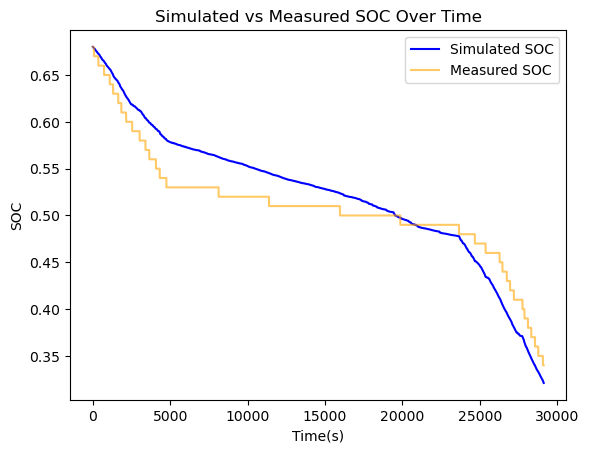

In [324]:
# 画图
# plt.figure(figsize=(12, 6))
plt.plot(times, res_soc, label='Simulated SOC', color='blue')
plt.plot(times, data['SOC'].values, label='Measured SOC', color='orange', alpha=0.6)
plt.xlabel('Time(s)')
plt.ylabel('SOC')
plt.legend()
plt.title('Simulated vs Measured SOC Over Time')
plt.show()

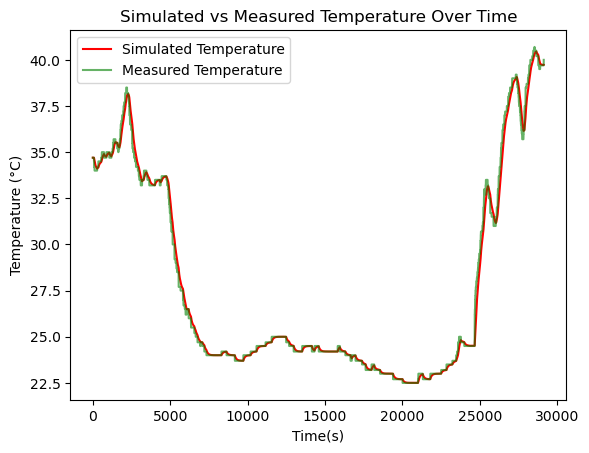

In [325]:
# 温度曲线
plt.plot(times, res_temp, label='Simulated Temperature', color='red')
plt.plot(times, data['Temperature(°C)'].values, label='Measured Temperature', color='green', alpha=0.6)
plt.xlabel('Time(s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Simulated vs Measured Temperature Over Time')
plt.show()

In [326]:
# 计算温度误差
temp_error = res_temp - data['Temperature(°C)'].values
mae_temp = np.mean(np.abs(temp_error))
print(f'Mean Absolute Error in Temperature: {mae_temp:.2f} °C')

Mean Absolute Error in Temperature: 0.20 °C


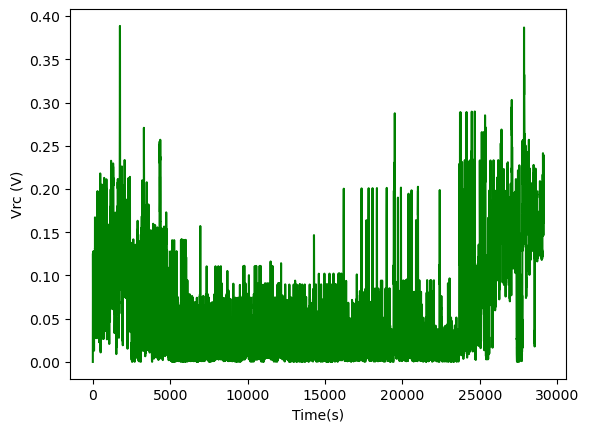

array([0.        , 0.06169638, 0.09140394, 0.10334358, 0.11249108,
       0.11182726, 0.11299967, 0.11488511, 0.12540044, 0.11673258])

In [327]:
# Vrc曲线
plt.plot(times, res_vrc, label='Vrc', color='green')
plt.xlabel('Time(s)')
plt.ylabel('Vrc (V)')
plt.show()
res_vrc[:10]

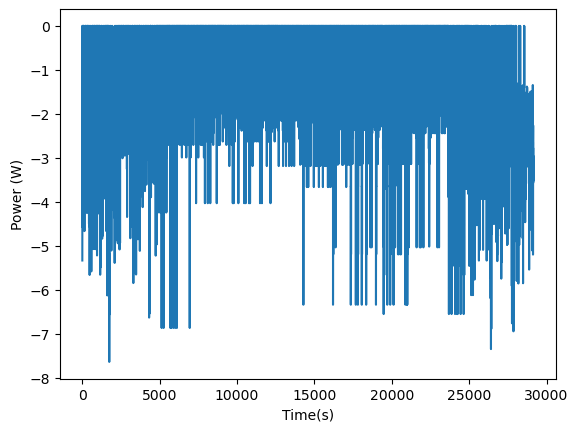

In [328]:
# 功率曲线
# plt.plot(times[5000:7000], powers[5000:7000])
plt.plot(times, powers)
plt.xlabel('Time(s)')
plt.ylabel('Power (W)')
plt.show()

In [329]:
# 计算误差
from sklearn.metrics import mean_absolute_error, mean_squared_error

def check_accuracy(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    max_err = np.max(np.abs(real - pred))
    
    print(f"--- 准确度评估 ---")
    print(f"MAE  : {mae:.4f} (平均偏差 {mae*100:.2f}%)")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAXE : {max_err:.4f} (最大偏差 {max_err*100:.2f}%)")
    
    return mae, rmse, max_err

check_accuracy(data['SOC'].values, res_soc)

--- 准确度评估 ---
MAE  : 0.0239 (平均偏差 2.39%)
RMSE : 0.0272
MAXE : 0.0509 (最大偏差 5.09%)


(0.023944385664197824,
 np.float64(0.027248790294346556),
 np.float64(0.05089794050076757))

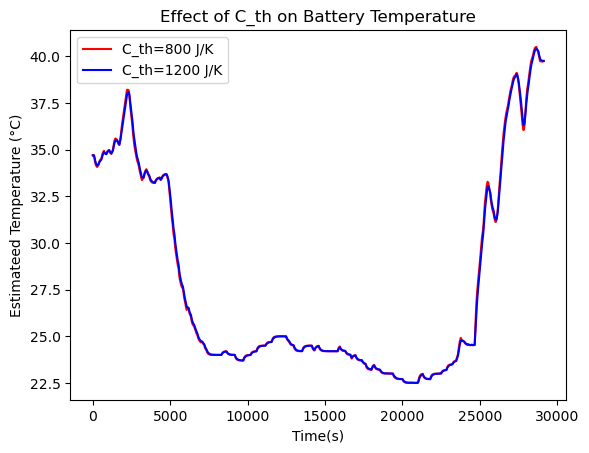

In [330]:
# 敏感性检验

# C_th变化对温度的影响
# C_th = 800 J/K
res_soc_c800, res_vrc_c800, res_temp_c800 = solve_battery_soc(-powers, times, temps, 
                                initial_soc=data['SOC'].values[0],
                                capacity=6.0,    # Ah
                                r_in=0.45,      # Ohm
                                r0=0.22,        # Ohm
                                c0=23,          # F
                                ocv_func=ocv,
                                c_th=800.0,    # J/K
                                h=10.0,         # W/K
                                mode='normal',
                                initial_vrc=0.0)
plt.plot(times, res_temp_c800, label='C_th=800 J/K', color='red')
# C_th = 1200 J/K
res_soc_c1200, res_vrc_c1200, res_temp_c1200 = solve_battery_soc(-powers, times, temps, 
                                initial_soc=data['SOC'].values[0],
                                capacity=6.0,    # Ah
                                r_in=0.45,      # Ohm
                                r0=0.22,        # Ohm
                                c0=23,          # F
                                ocv_func=ocv,
                                c_th=1200.0,    # J/K
                                h=10.0,         # W/K
                                mode='normal',
                                initial_vrc=0.0)
plt.plot(times, res_temp_c1200, label='C_th=1200 J/K', color='blue')
# 原始C_th = 1000 J/K
# plt.plot(times, res_temp, label='C_th=1000 J/K', color='green')
plt.xlabel('Time(s)')
plt.ylabel('Estimateed Temperature (°C)')
plt.legend()
plt.title('Effect of C_th on Battery Temperature')
plt.show()